<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    TimeSeriesSplit,
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [2]:
# Считываем данные из файла
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
# Отсортируем значения в таблицу
data.sort_index(inplace = True)
# Проведем ресемплирование в соответствии с условиями 
data = data.resample('1H').sum()

In [3]:
display(data.head())
display(data.tail())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Для прогнозирования количества заказов в аэропортах на ближайший час в нашем распоряжении имеются исторические данные о количестве заказов в период с 1 марта 2018 года по 31 августа 2018 года. Для построения прогноза датасет был ресемплирован по одному часу.

## Анализ

In [4]:
# Проведем декомпозицию ряда
decomposed = seasonal_decompose(data)

In [5]:
sns.set(rc={"figure.figsize":(12 , 6),
           "xtick.labelsize":14,
           "ytick.labelsize":14,
           "axes.labelsize": 16})

In [6]:
def decomposition_data(data_full, 
                       period_start: str, 
                       period_finish: str, 
                       resample: str, 
                       siries_name: str):
    """
    Функция принимает датафрейм, начало анализируемого периода,
    окончание анализируемого периода, период для ресемплирования
    и название ряда. Функция возвращает декомпозицию ряда на тренд,
    сезонную и случайную составляющие.
    """
    data_analysis = data_full[
        datetime.strptime(period_start, '%Y:%m:%d'):
        datetime.strptime(period_finish, '%Y:%m:%d')
    ].resample(str(resample)).sum()

    decomposed = seasonal_decompose(data_analysis)

    sns.lineplot(data = decomposed.trend)
    plt.title('Тренд', size= 16)
    plt.xlabel('Дата')
    plt.xticks(rotation=90)
    plt.ylabel(str(siries_name))
    plt.show();

    sns.lineplot(data = decomposed.seasonal)
    plt.title('Сезонная составляющая', size= 16)
    plt.xlabel('Дата')
    plt.xticks(rotation=90)
    plt.ylabel(str(siries_name))
    plt.show();

    sns.lineplot(data = decomposed.resid)
    plt.title('Остатки', size= 16)
    plt.xlabel('Дата')
    plt.xticks(rotation=90)
    plt.ylabel(str(siries_name))
    plt.show();

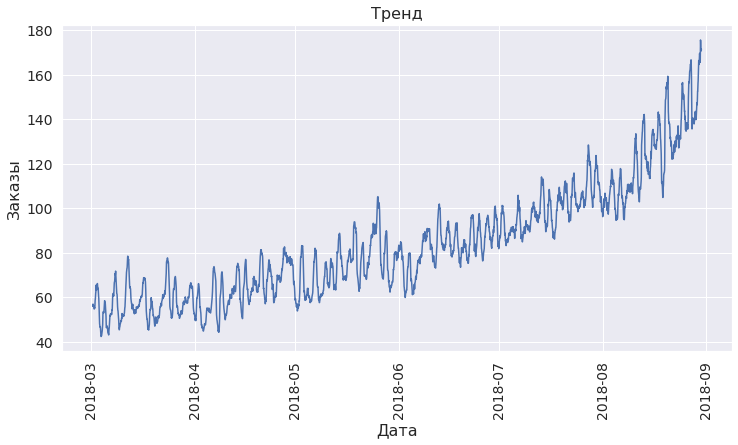

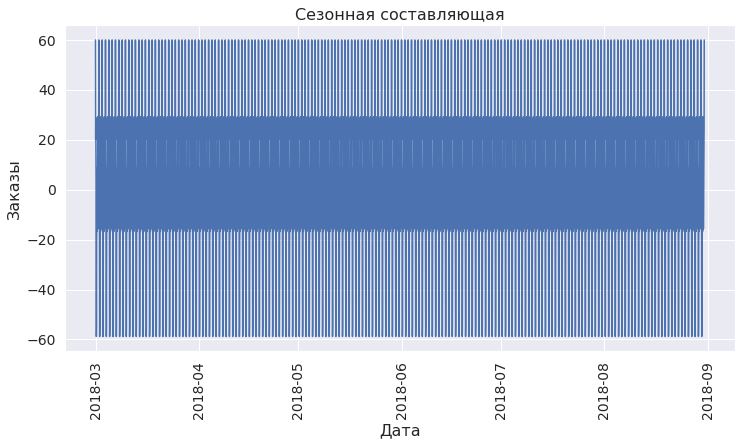

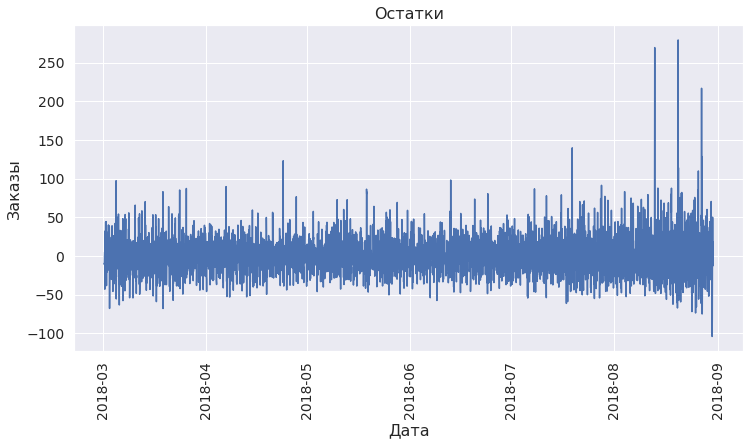

In [7]:
# Проверим наличие суточной сезонности
decomposition_data(data, '2018:03:01', '2018:08:31', '1H', 'Заказы')

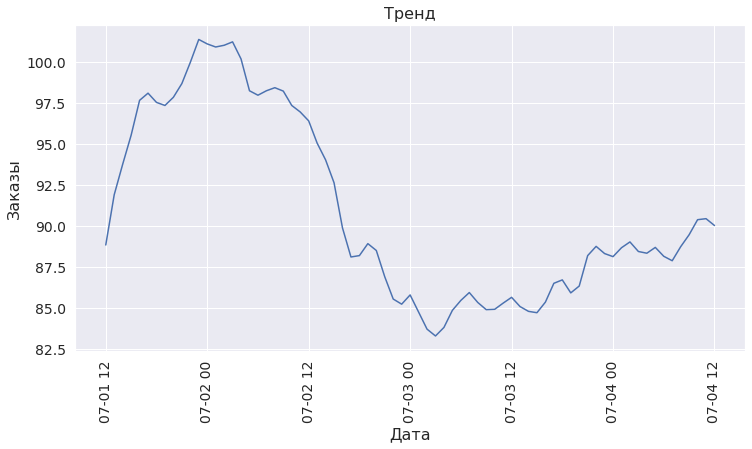

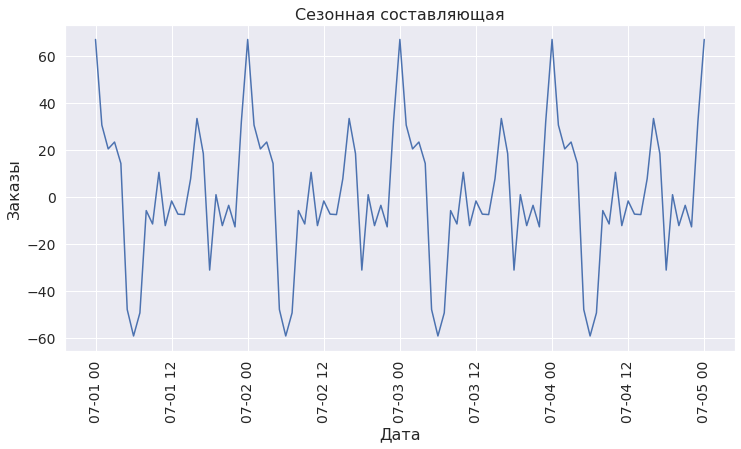

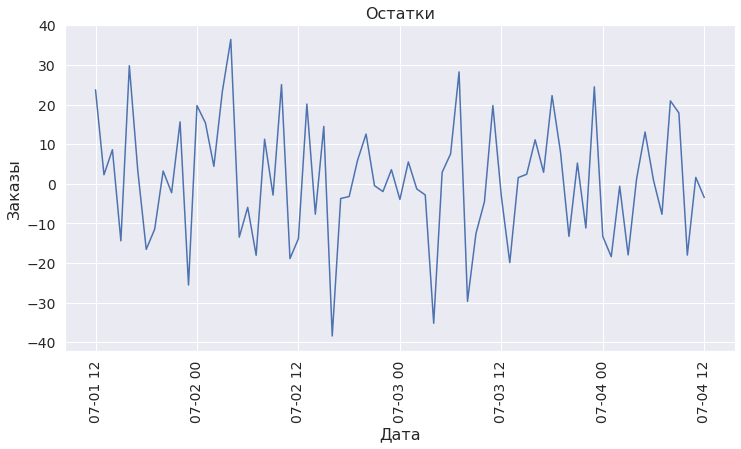

In [8]:
# Для более информативных графиков изменим период
decomposition_data(data, '2018:07:01', '2018:07:05', '1H', 'Заказы')

По результатам декомпозии можем сделать вывод о наличии в исследуемом ряде данных недельной сезонности.

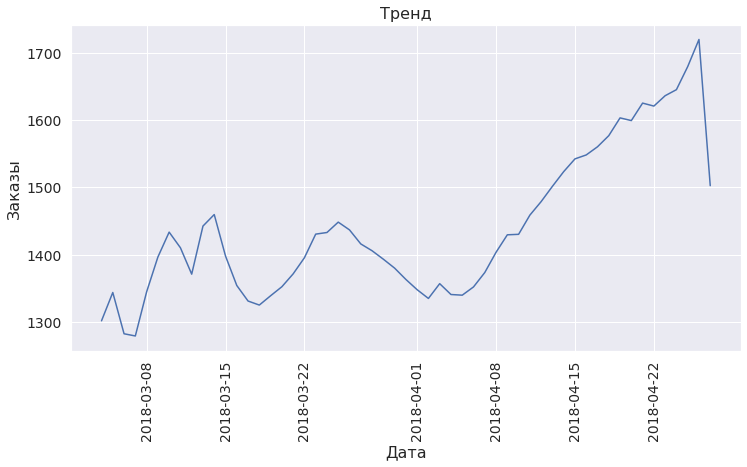

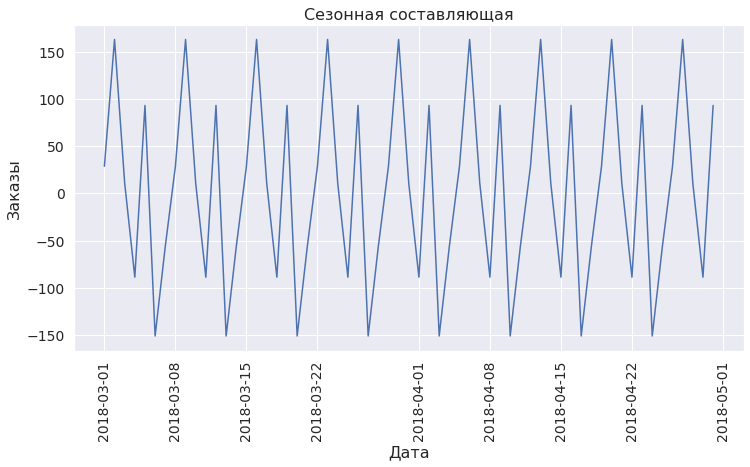

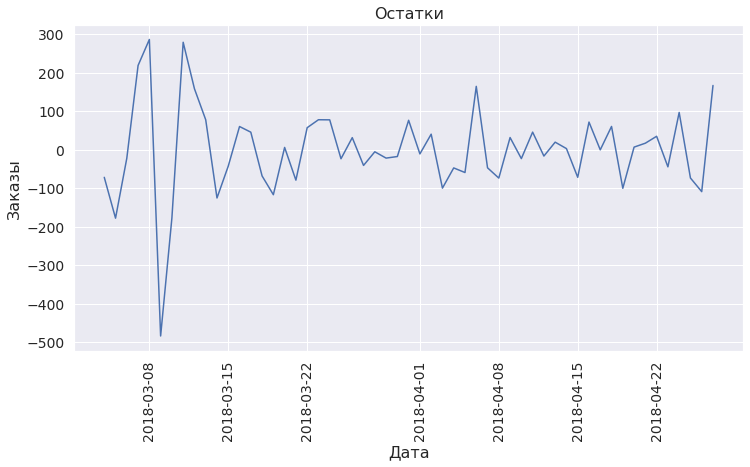

In [9]:
# Проверим наличие недельной сезонности
# Ресемплируем данные по дням, рассмотрим период
# с 1 марта по 30 апреля
decomposition_data(data, '2018:03:01', '2018:04:30', '1D', 'Заказы')

По результатам декомпозии можем сделать вывод о наличии в исследуемом ряде данных суточной сезонности. 

В результате декомпозиции мы выделили тренд, сезонную и случайные составляющие при проверке наличия суточной и недельной сезонностей. Несмотря на наличие ярко выраженной сезонности, линия тренда является достаточно неровной, а на конце временного ряда увеличиваются выбросы случайной составляющей ряда (значения, которые не могут быть объяснены трендом и сезонной составляющей). Для оценки корректности прогнозирования данных такого радя проверим его на стационарность.

Проведем дополнительные расчеты для анализа ряда данных.

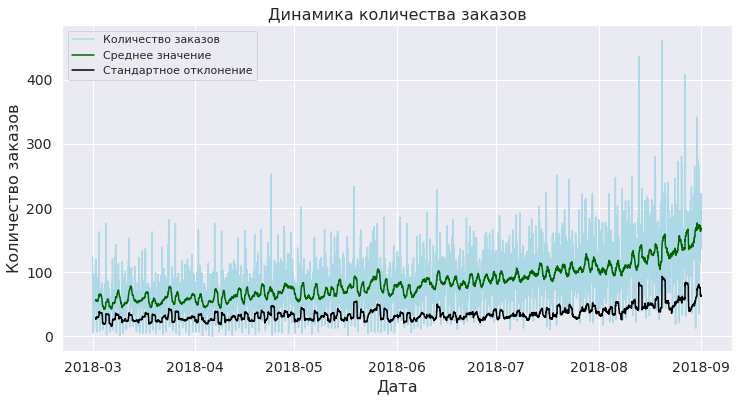

In [10]:
# Рассчитаем скользящее среднее значение
data['mean'] = data['num_orders'].rolling(24).mean()
# Рассчитаем стандартное отклонение
data['std'] = data['num_orders'].rolling(24).std()
# Визуализируем данные
sns.lineplot(data = data['num_orders'], 
             label = 'Количество заказов', 
             color = 'lightblue')
sns.lineplot(data = data['mean'],
             label = 'Среднее значение',
             color = 'darkgreen')
sns.lineplot(data = data['std'],
             label = 'Стандартное отклонение',
             color = 'black')
plt.title('Динамика количества заказов', size= 16)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Для проверки ряда на стационарность проведем расширенный тест Дики-Фуллера. Нулевой гипотезой является нестационарность исследуемого ряда, альтернативной - ряд является стационарным:

H_0 : Временной ряд является нестационарным.

H_A : временной ряд является стационарным.

In [11]:
# Проведем расширенный тест Дики-Фуллера
print(f'p-value = {round(adfuller(data["num_orders"])[1], 4)}')

p-value = 0.0289


Так как p-value = 0,0289, что меньше 0.05, отвергаем нулевую гипотезу на 5%-м уровне значимости. Следовательно, ряд является стационарным.

На данном этапе мы проанализировали ряд данных, выделив тренд, сезонную и случайную составляющие, а также проверили ряд на стационарность. Так как ряд является стационарным, можем приступить к решению поставленной задачи прогнозирования.

## Обучение

Предположим, что значения ряда зависят от своих собственных ретроспективных значений (что объясняется наличием сезонности), а также от периода фиксации наблюдения (трендовая составляющая).

Напишем функцию, генерирующую вспомогательные признаки.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag).copy()

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

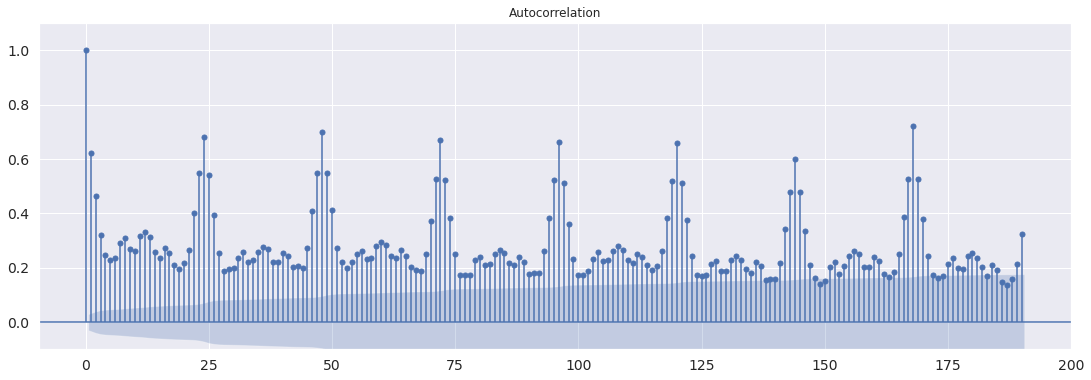

In [13]:
# Проведем проверку лагов на значимость
taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Анализ автокорреляции показал, что практически все лаги до 170 являются значимыми. Это объясняется наличием недельной и суточной сезонностей. Добавим в датафрейм дополнительные признаки. 

In [14]:
make_features(data, 168, 24)

In [15]:
# Разделим данные на тестовую и тренировочные выборки
data = data.drop(['mean', 'std'], axis=1)
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [16]:
train.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Удалим из тренировочной выборки наблюдения с пропущенными
# значениями, образовавшимися в результате генерации 
# дополнительных признаков
train = train.dropna()
# Задаем определяющие (features) и определяемые (target) признаки для каждой выборки
# Тренировочная выборка
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis = 1)
# Тестовая выборка
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis = 1)

STATE = 442

### Линейная регрессия

In [ ]:
%%time
tscv = TimeSeriesSplit(n_splits=3) # добавил TimesSeriesSplit()
model = LinearRegression()
# Для кросс-валидации модели линейной регрессии
# используем cross_val_score. Функция cross_val_score 
# создает 3 блока и возвращает список оценок, в данном случае
# отрицательное среднее квадратическое отклонение
rmse_linear_neg = cross_val_score(model, 
                                  features_train,
                                  target_train, 
                                  cv=tscv, 
                                  scoring='neg_mean_squared_error')
# Рассчитаем 
rmse_linear = 0
for i in range(len(rmse_linear_neg)):
    rmse_linear += (-rmse_linear_neg[i]) ** 0.5
rmse_linear /= len(rmse_linear_neg)    
print("RMSE на обучающей выборке модели линейной регрессии составил:", 
      round(rmse_linear, 6))
rmse_linear_neg

### RandomForestRegressor

In [ ]:
%%time
# Определяем модель
model = RandomForestRegressor(random_state=STATE)

# Задаем параметры для GridSearchCV
params = {'max_depth':range(10, 26, 5), 
          'n_estimators': range(100, 501, 100),
          'min_samples_leaf': range(1, 8, 3)
                 }

grid_rand_forest = GridSearchCV(model, 
                                params,
                                cv = tscv, 
                                scoring = 'neg_mean_squared_error', 
                                n_jobs = -1)
grid_rand_forest.fit(features_train, target_train)

print(f'RMSE для лучшей модели случайного леса составило: '
      f'{(-grid_rand_forest.best_score_) ** 0.5:.6}')
print(f'Гиперпараметры лучшей модели: {grid_rand_forest.best_params_}')

### CatBoostRegressor

In [ ]:
%%time
# Определяем модель
cat = CatBoostRegressor(random_state = STATE)
# Задаем параметры для GridSearchCV
params = {'depth': range(10, 15),
          'l2_leaf_reg': [3, 5]}

grid_cat = GridSearchCV(cat, 
                        params, 
                        cv = tscv, 
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        error_score='raise')
grid_cat.fit(features_train, target_train)

print(f'RMSE для лучшей модели CatBoost: '
      f'{(-grid_cat.best_score_) ** 0.5:.6}')
print(f'Гиперпараметры лучшей модели: {grid_cat.best_params_}')

### LightGBM

In [ ]:
%%time
# Определяем модель
model = lgb.LGBMRegressor(random_state = STATE)
# Задаем параметры для GridSearchCV
params = {
    'max_depth':range(10, 51, 5),
    'reg_alpha':[0.1, 0.3, 0.5, 0.7],
    'num_leaves':range(2, 10, 3)}

grid_lgbm = GridSearchCV(model, 
                         params, 
                         cv = tscv, 
                         scoring = 'neg_mean_squared_error', 
                         n_jobs = -1)
grid_lgbm.fit(features_train, target_train)

print(f'RMSE для лучшей модели бустинга составило: '
      f'{(-grid_lgbm.best_score_) ** 0.5:.6}')
print(f'Гиперпараметры лучшей модели: {grid_lgbm.best_params_}')

In [ ]:
data_result = pd.DataFrame(
    [
        ['LinearRegressor', 
         round(rmse_linear, 4)],
        ['RandomForestRegressor', 
         round((-grid_rand_forest.best_score_)**0.5, 4)],
        ['LightGBM', 
         round((-grid_lgbm.best_score_)**0.5, 4)], 
        ['CatBoostRegressor', 
         round((-grid_cat.best_score_)**0.5, 4)]
    ], 
    columns = ['model', 'RMSE']
)

data_result = data_result.set_index('model')

data_result

Нами были обучены следующие модели:
 - модель линейной регрессии LinearRegressor;
 - модель случайного леса RandomForestRegressor;
 - модель градиентного бустинга LightGBM;
 - модель градиентного бустинга CatBoostRegressor.

Качество моделей оценивалось по значениям среднего квадратического отклонения (RMSE) - лучшей признается та, значение RMSE которой минимально. По итогам исследования наименьшее значение RMSE показала модель линейной регрессии. Проверим эту модель на тестовой выборке. 

## Тестирование

In [ ]:
model = LinearRegression()
model.fit(features_train, target_train)
prediction_test = model.predict(features_test)
rmse_test =  mean_squared_error(target_test, prediction_test, squared=False)
print("RMSE модели линейной регрессии на тестовой выборки:", 
      round(rmse_test, 14))

RMSE модели оказалось ниже порогового значения (48), следовательно, можем считать поставленную перед нами задачу выполненной.

Для проверки адекватности нашей модели сравнили качество предсказания с наивной моделью.  

In [ ]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE наивной модели:", mean_squared_error(test['num_orders'], pred_previous['num_orders'], squared = False))

RMSE наивной модели оказалось выше, чем у модели линейной регрессии и превысило пороговое значение (48).

## Вывод

Для прогнозирования количества заказов в аэропортах на ближайший час в нашем распоряжении были исторические данные о количестве заказов в период с 1 марта 2018 года по 31 августа 2018 года. Для построения прогноза датасет был ресемплирован по одному часу. 

В результате декомпозиции мы выделили тренд, сезонную и случайные составляющие. Убедившись в стационарности исследуемого ряда приступили к прогнозированию значений. 

Мы предположили, что значения ряда зависят от своих собственных ретроспективных значений (что объясняется наличием сезонности), а также от периода фиксации наблюдения (трендовая составляющая).


Нами были обучены следующие модели:

 - модель линейной регрессии LinearRegressor;
 - модель случайного леса RandomForestRegressor;
 - модель градиентного бустинга LightGBM;
 - модель градиентного бустинга CatBoostRegressor.

Качество моделей оценивалось по значениям среднего квадратического отклонения (RMSE) - лучшей признается та, значение RMSE которой минимально. По итогам исследования наименьшее значение RMSE показала модель линейной регрессии. Нами осуществлена проверка этой модели на тестовой выборке.

RMSE модели оказалось ниже порогового значения (48), следовательно, можем считать поставленную перед нами задачу выполненной.